# Quickstart
Here is a quick demonstration of some of the main functionality of Invert4Geom. This assumes you are familar with Python and have [successfully installed](install.md) this packaged. See the [tutorials](tutorial/index.md) for a step-by-step introduction to Invert4Geom, and the [how-to guides](how_to/index.md) for more in-depth guides for specific features.

## Import packages

In [1]:
import os

import numpy as np
import polartoolkit as ptk
import verde as vd

import invert4geom

os.environ["POLARTOOLKIT_EPSG"] = "3857"

/home/sungw937/miniforge3/envs/invert4geom/lib/python3.12/site-packages/UQpy/__init__.py:6: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



## Create observed gravity data

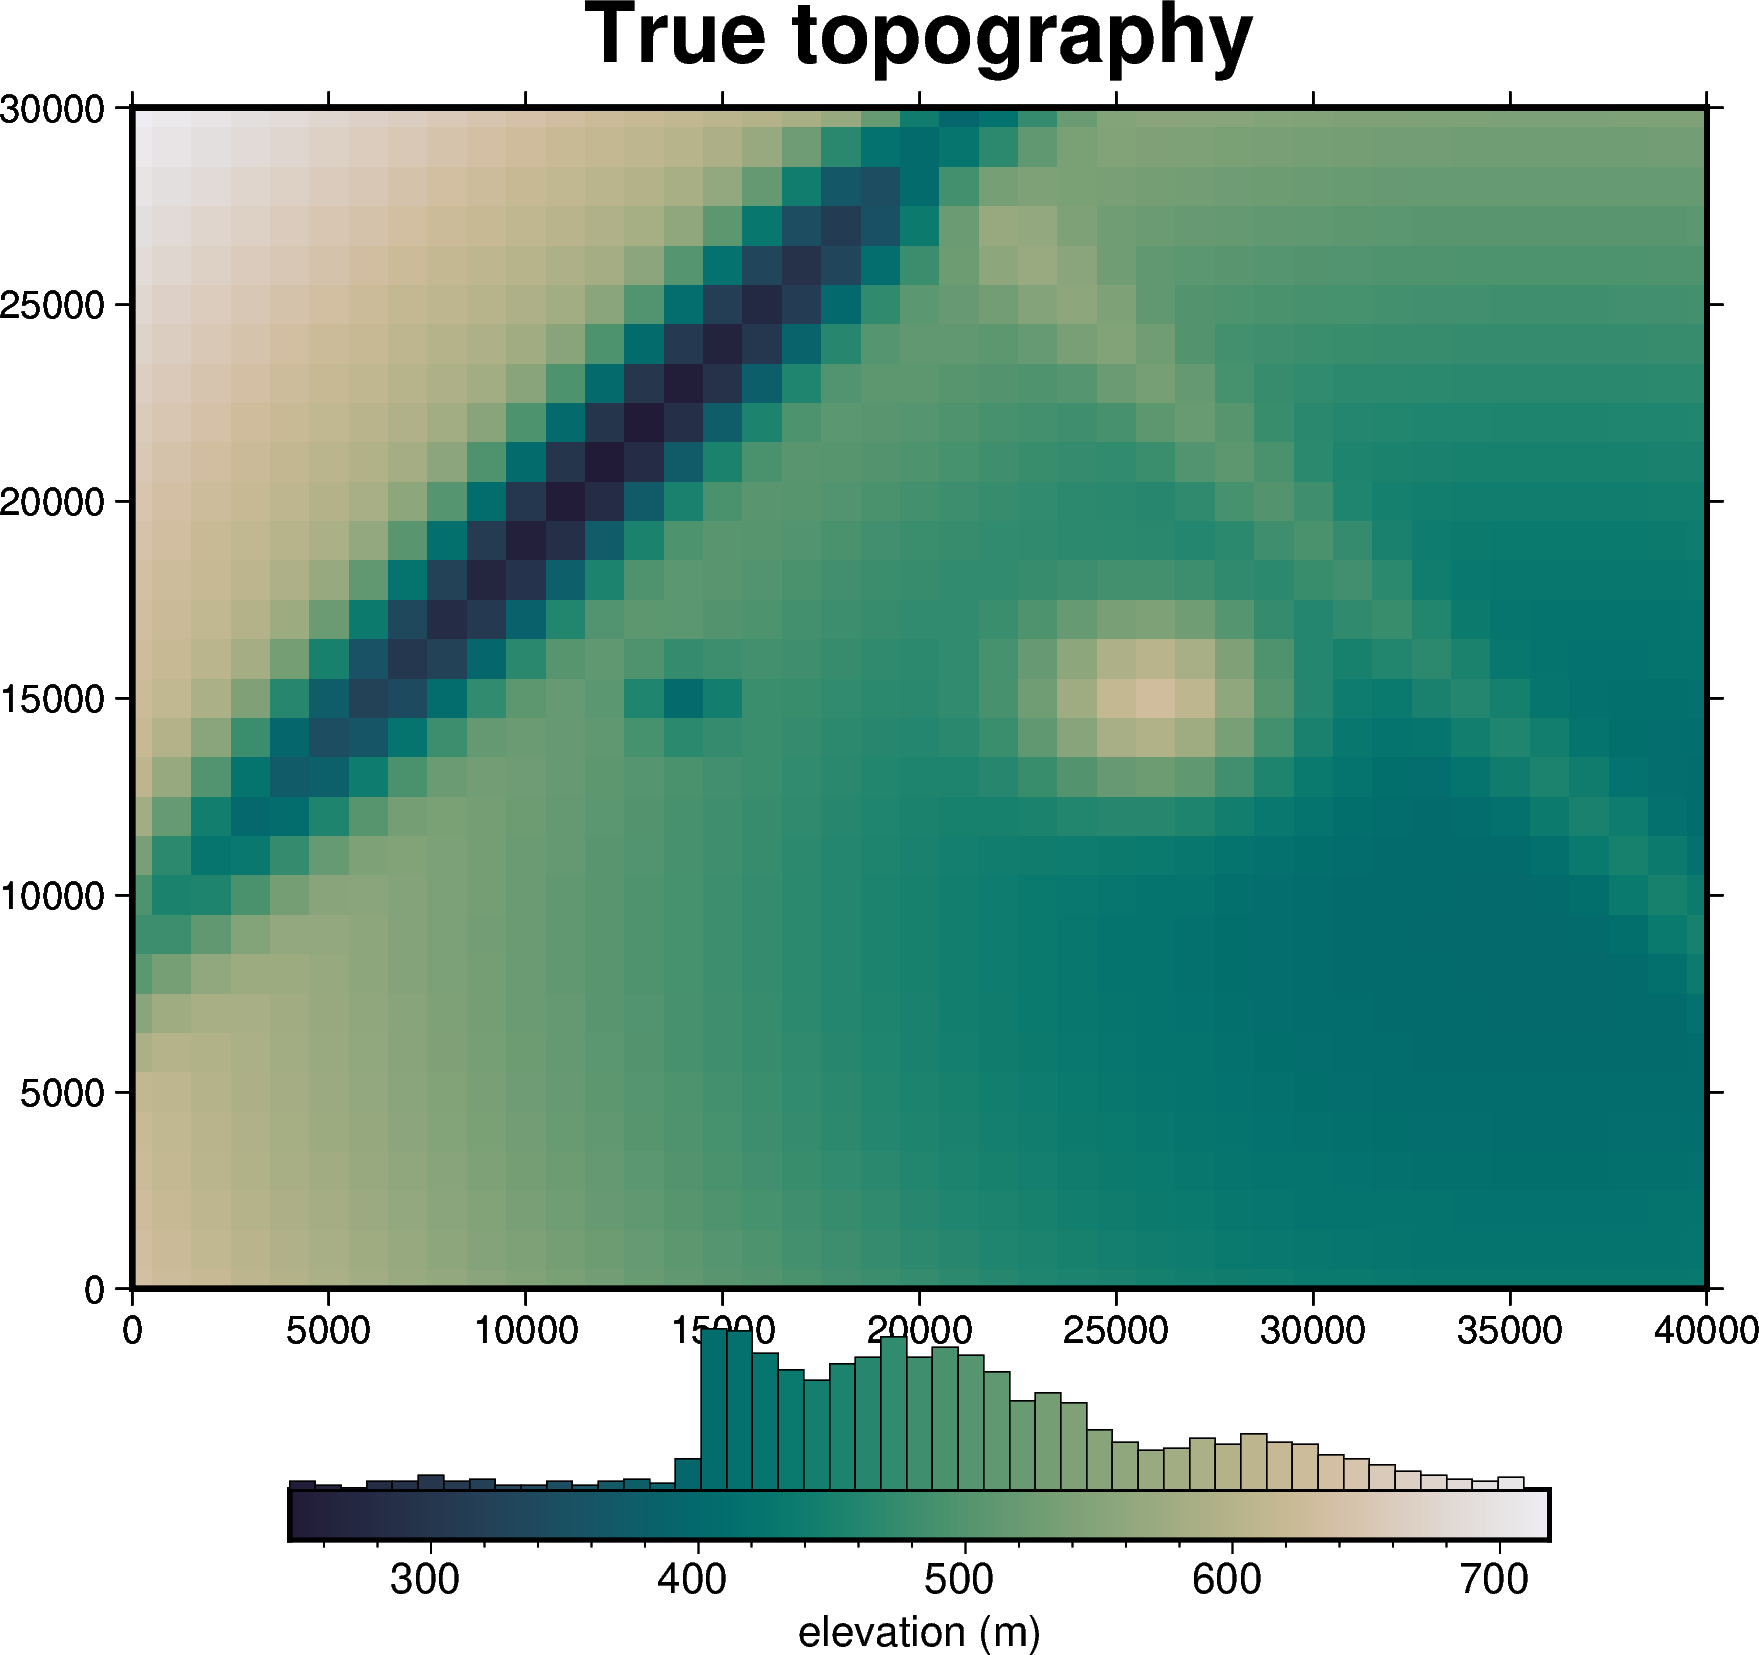

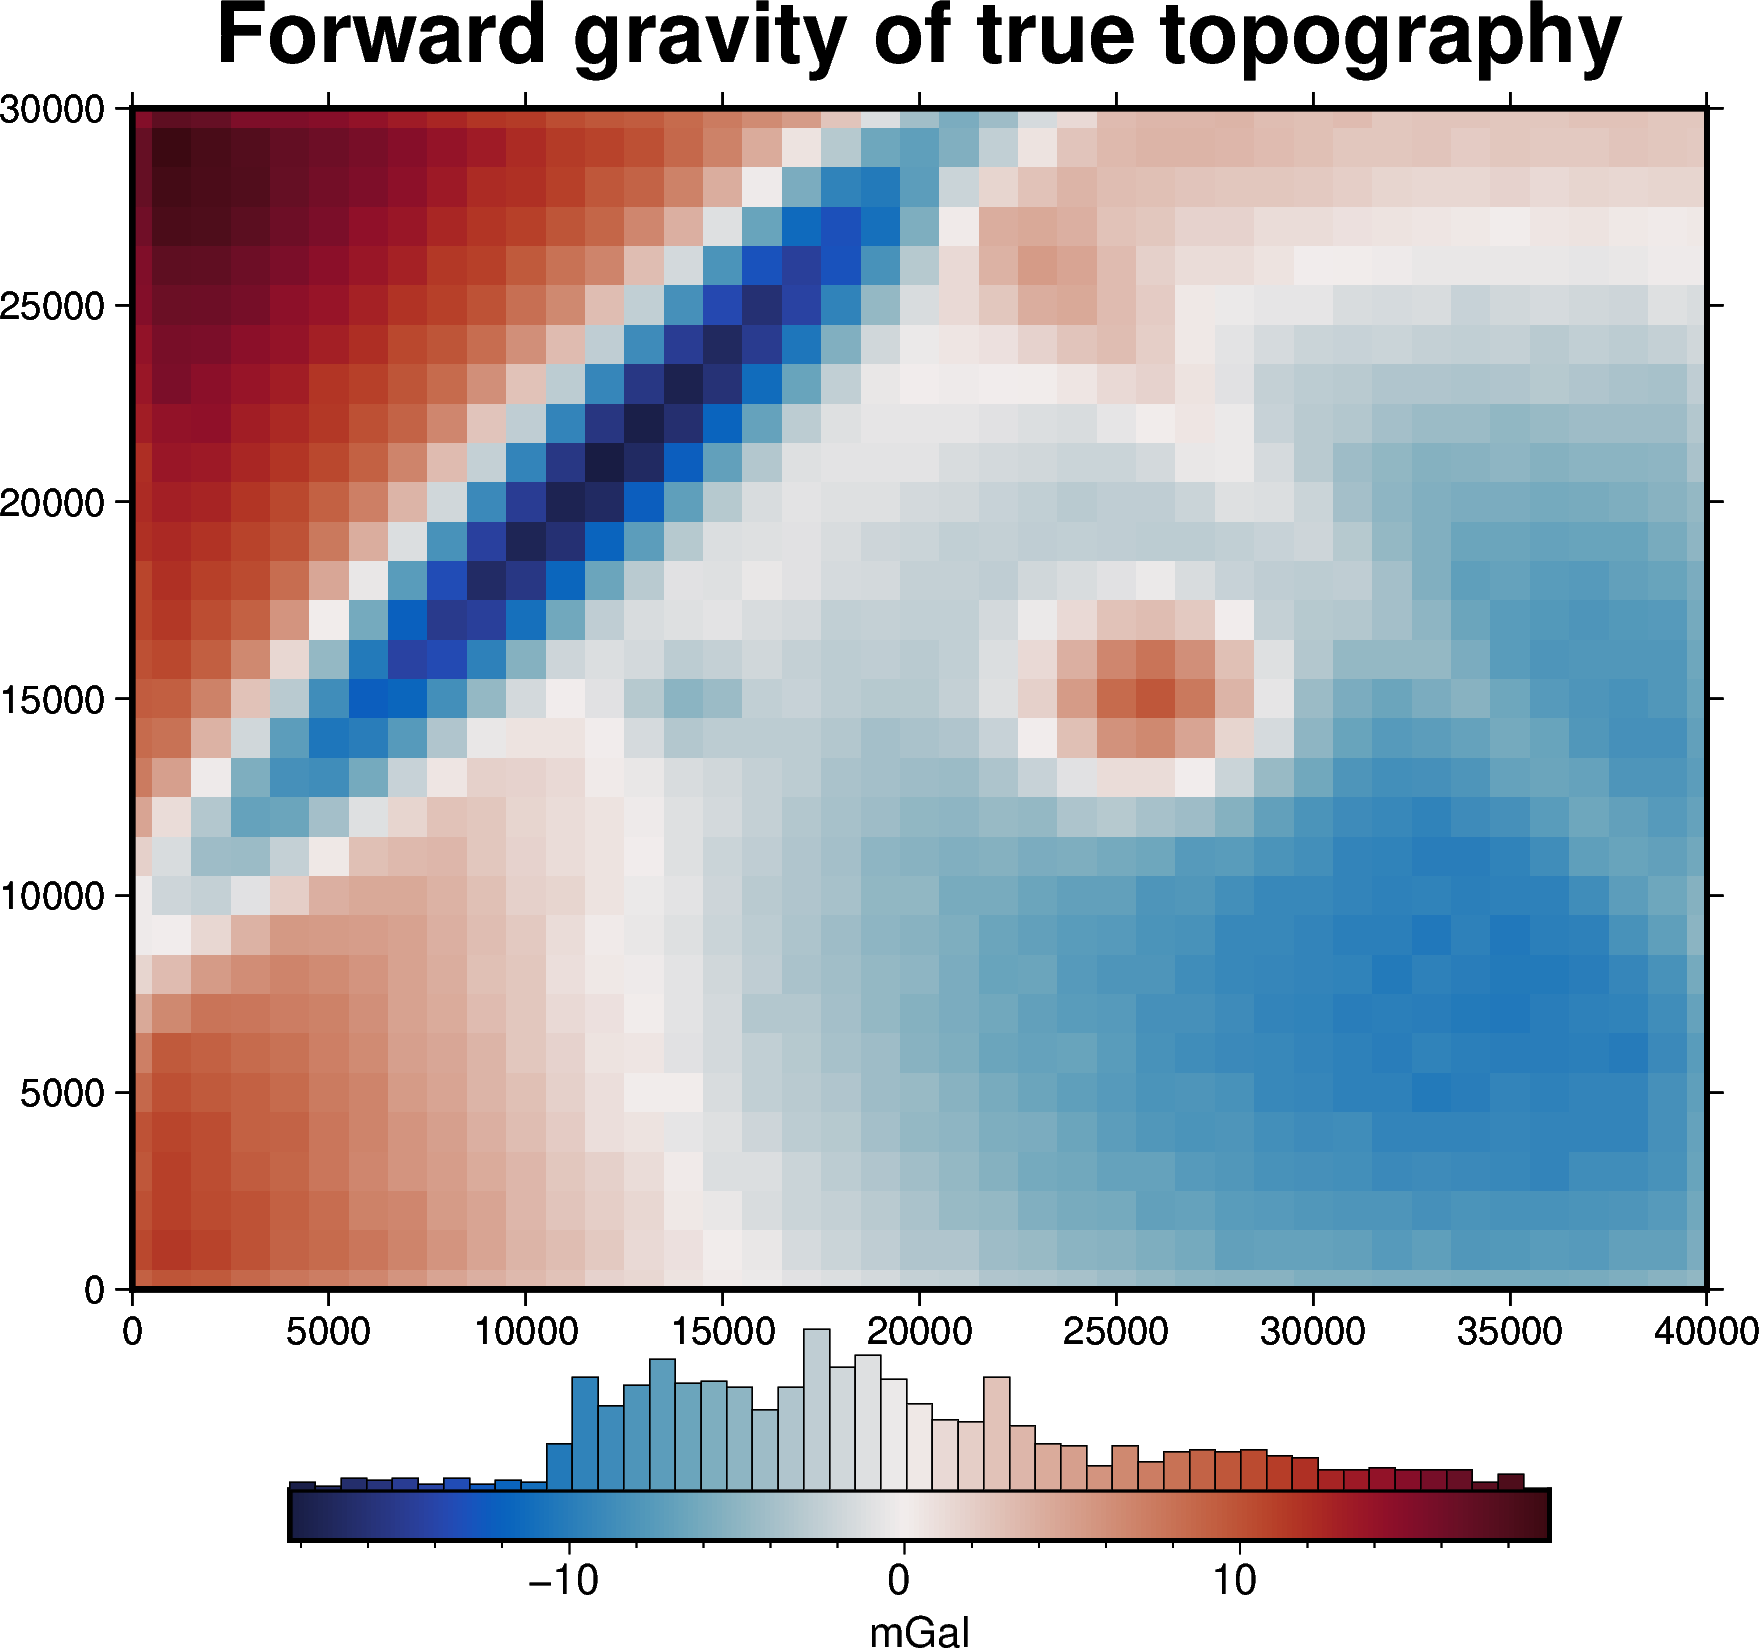

In [2]:
true_topography, _, _, observed_gravity = invert4geom.load_synthetic_model(
    spacing=1000,
    region=(0, 40000, 0, 30000),
    density_contrast=2670 - 1,  # density contrast between rock and air
    zref=500,
    gravity_noise=0.2,
    plot_gravity=True,
    plot_topography=True,
)

## Initialize the gravity data class

In [3]:
data = invert4geom.create_data(observed_gravity)

## Create a starting topography grid

In [4]:
# make a flat grid at 500 m
grid_coords = vd.grid_coordinates(
    spacing=1000,
    region=(0, 40000, 0, 30000),
)
starting_topography = vd.make_xarray_grid(
    grid_coords,
    data=np.ones_like(grid_coords[0]) * 500,
    data_names="upward",
)

## Create a model

In [5]:
model = invert4geom.create_model(
    zref=500,
    density_contrast=2670 - 1,
    topography=starting_topography,
)
model

<xarray.Dataset> Size: 92kB
Dimensions:                (northing: 31, easting: 41)
Coordinates:
  * northing               (northing) float64 248B 0.0 1e+03 ... 2.9e+04 3e+04
  * easting                (easting) float64 328B 0.0 1e+03 ... 3.9e+04 4e+04
    top                    (northing, easting) float64 10kB 500.0 ... 500.0
    bottom                 (northing, easting) float64 10kB 500.0 ... 500.0
Data variables:
    density                (northing, easting) int64 10kB 2669 2669 ... 2669
    thickness              (northing, easting) float64 10kB 0.0 0.0 ... 0.0 0.0
    starting_topography    (northing, easting) float64 10kB 500.0 ... 500.0
    topography             (northing, easting) float64 10kB 500.0 ... 500.0
    mask                   (northing, easting) float64 10kB 1.0 1.0 ... 1.0 1.0
    upper_confining_layer  (northing, easting) float64 10kB nan nan ... nan nan
    lower_confining_layer  (northing, easting) float64 10kB nan nan ... nan nan
Attributes:
    zref:              500
    density_contrast:  2669
    region:            (0.0, 40000.0, 0.0, 30000.0)
    spacing:           1000.0
    buffer_width:      0
    inner_region:      (0.0, 40000.0, 0.0, 30000.0)
    dataset_type:      model
    model_type:        prisms

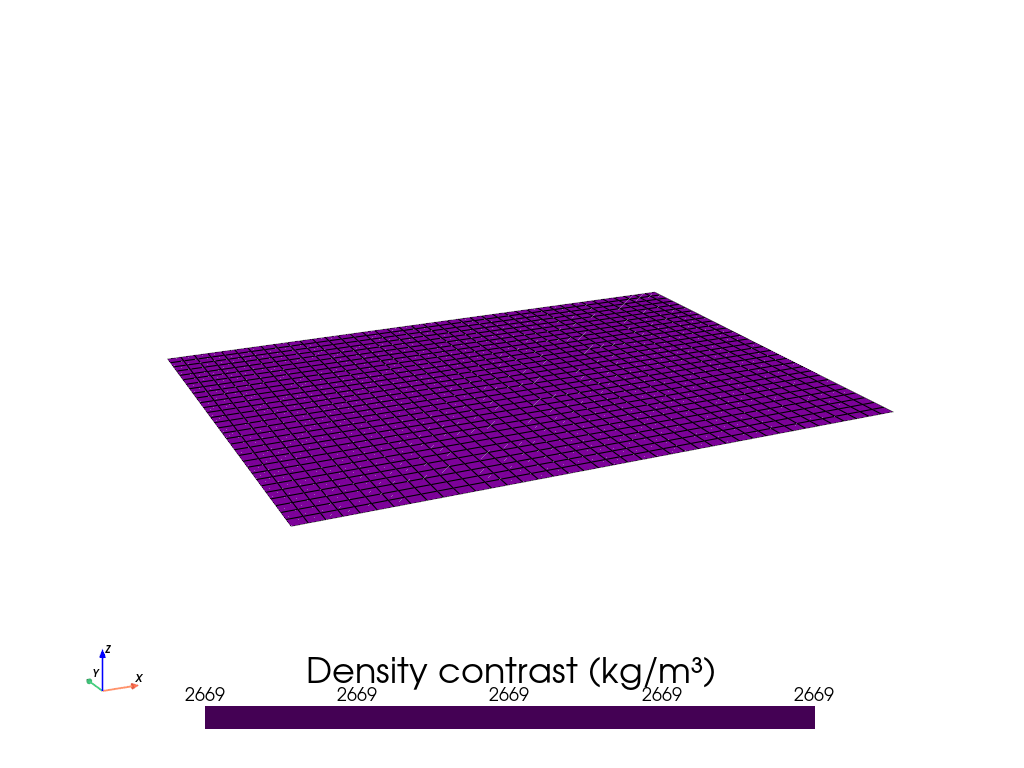

In [6]:
model.inv.plot_model(show_edges=True)

## Gravity misfit


In [7]:
data.inv.forward_gravity(
    model,
    progressbar=True,
)
data.inv.df.head()

  0%|          | 0/1271 [00:00<?, ?it/s]

,northing,easting,upward,gravity_anomaly,forward_gravity
0,0.0,0.0,1000.0,9.069604,-0.0
1,0.0,1000.0,1000.0,9.813227,-0.0
2,0.0,2000.0,1000.0,9.473334,-0.0
3,0.0,3000.0,1000.0,8.676493,-0.0
4,0.0,4000.0,1000.0,7.806311,-0.0


In [8]:
data.inv.regional_constant(
    constant=0,
)
data.inv.df.head()

,northing,easting,upward,gravity_anomaly,forward_gravity,misfit,reg,res,starting_forward_gravity,starting_misfit,starting_reg,starting_res
0,0.0,0.0,1000.0,9.069604,-0.0,9.069604,0.0,9.069604,-0.0,9.069604,0.0,9.069604
1,0.0,1000.0,1000.0,9.813227,-0.0,9.813227,0.0,9.813227,-0.0,9.813227,0.0,9.813227
2,0.0,2000.0,1000.0,9.473334,-0.0,9.473334,0.0,9.473334,-0.0,9.473334,0.0,9.473334
3,0.0,3000.0,1000.0,8.676493,-0.0,8.676493,0.0,8.676493,-0.0,8.676493,0.0,8.676493
4,0.0,4000.0,1000.0,7.806311,-0.0,7.806311,0.0,7.806311,-0.0,7.806311,0.0,7.806311


makecpt [ERROR]: Option T: min >= max


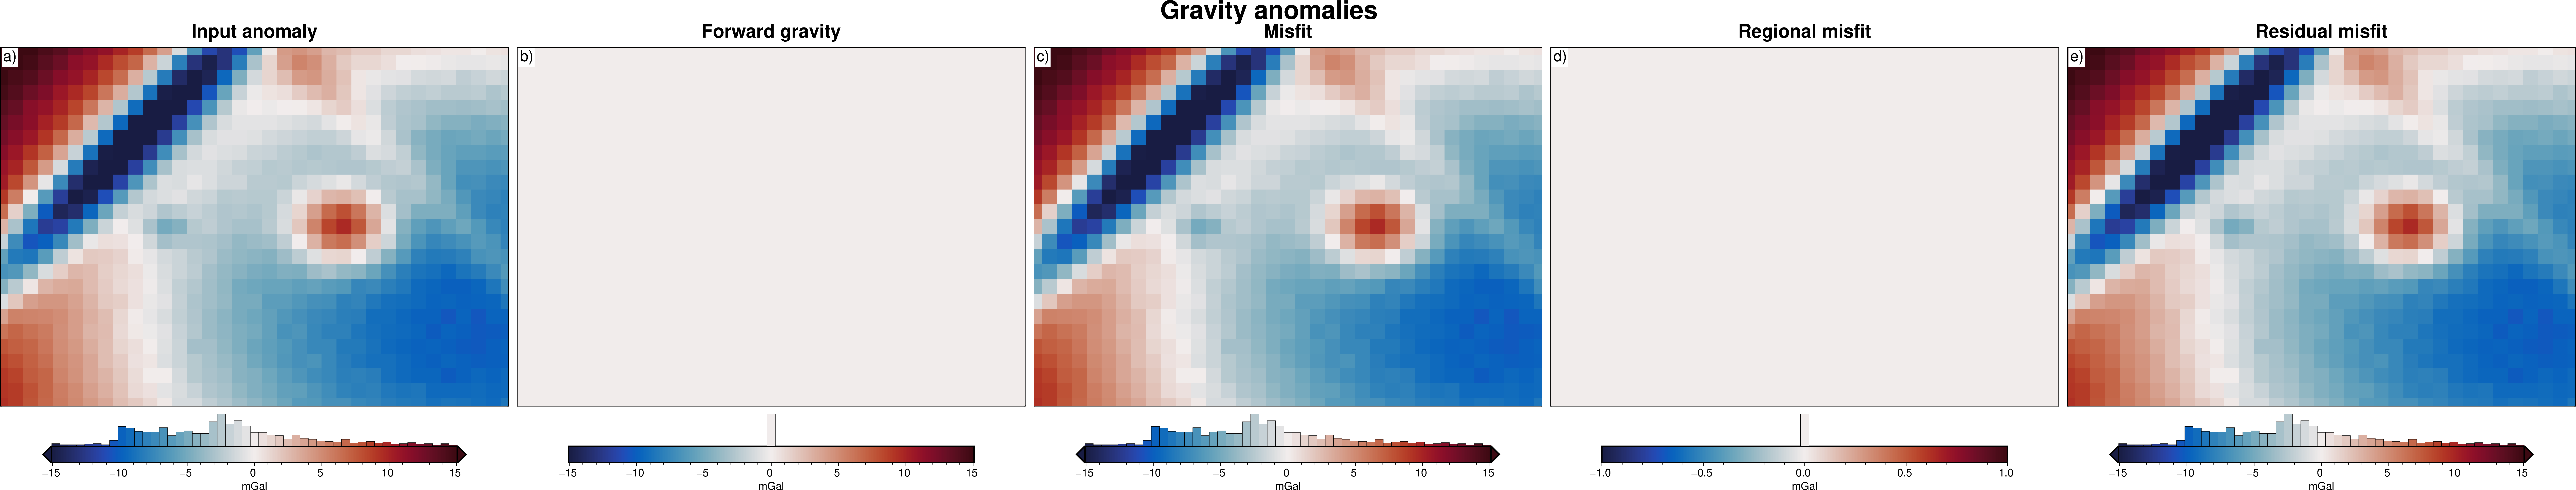

In [9]:
data.inv.plot_anomalies()

## Initialize the Inversion class

In [10]:
inv = invert4geom.Inversion(
    data,
    model,
    solver_damping=0.1,
    # set stopping criteria
    max_iterations=30,
    l2_norm_tolerance=0.45,
    delta_l2_norm_tolerance=1.005,
)

## Perform inversion

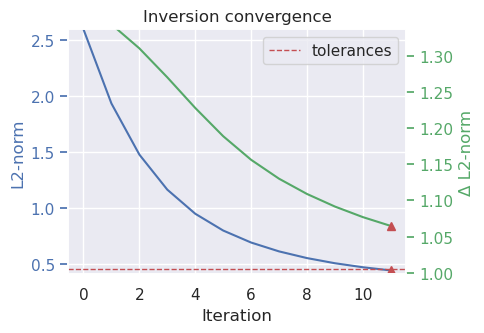

In [11]:
inv.invert(
    plot_dynamic_convergence=True,
)

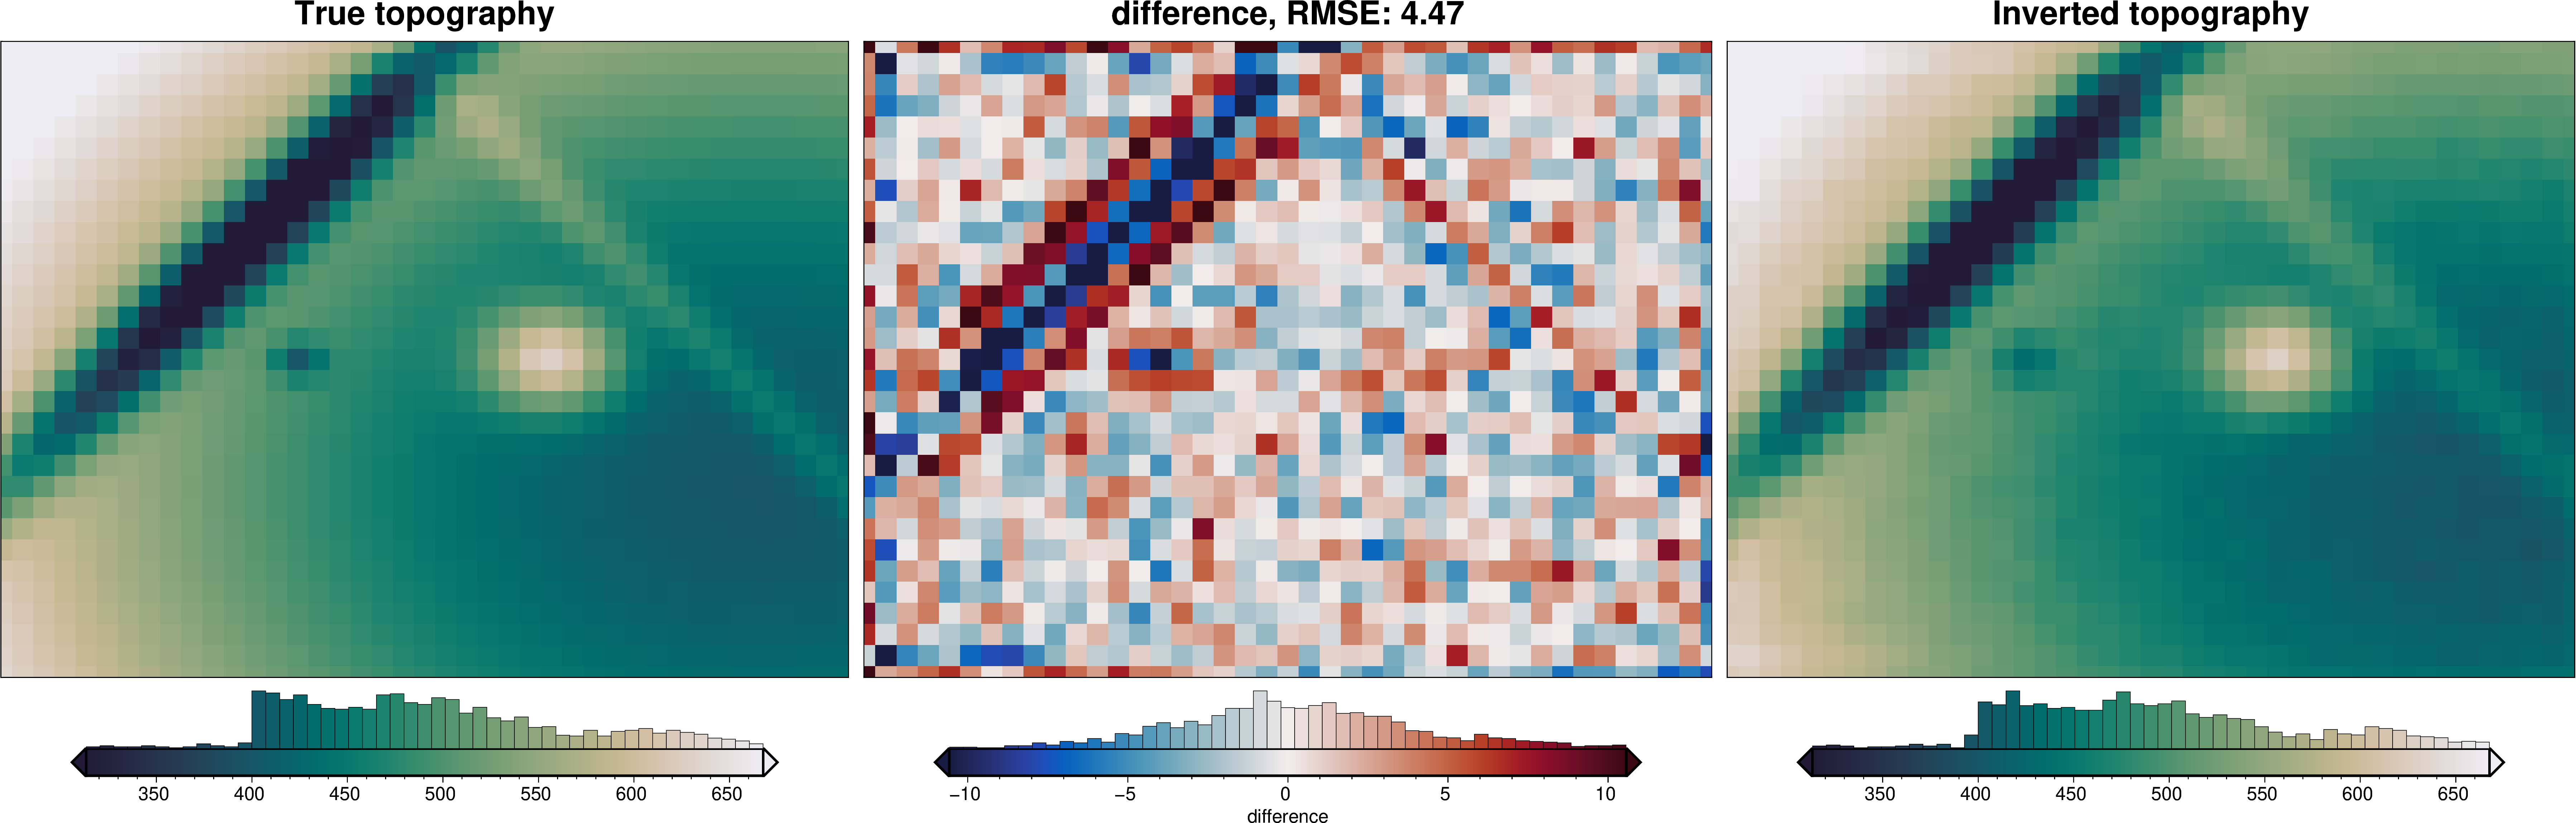

In [12]:
_ = ptk.grid_compare(
    true_topography,
    inv.model.topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    title="difference",
    reverse_cpt=True,
    cmap="rain",
)

As you can see, the inversion successfully recovered the true topography. The root mean square difference between the true and recovered topography is low, but this is not too surprising since we gave the inversion the true density contrast and reference level values.